In [2]:
from bs4 import BeautifulSoup
from random import randint, shuffle
from time import sleep
import re
import pandas as pd
import json
import math
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import os
from tqdm import tqdm_notebook as tqdm
import shutil
import numpy as np
import pandas_profiling
from wordcloud import WordCloud, STOPWORDS
import textwrap

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.float_format", "{:,.2f}".format)
pd.set_option("display.max_info_rows", 200)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("gist_stern", 15)


# Products on Sephora.com


In [3]:
# List of all products from Sephora as of June 24 with binary columns for categories

products = pd.read_csv("df_sephora.csv")
products.head()

,id,name,brand_id,brand_name,short_desc,long_desc,item,item_name,list_price,variation,variants,price_low,price_high,is_limited_edition,rating,review_count,user_favorites,categories,url,image_url,ingredients,suggested_usage,brand_long,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,vegan,cruelty_free,for_men
0,P180726,Pour Homme II,1063,Gucci,"An alluring fragrance heightened by a sensual, spicy soul, Gucci Pour Homme II is the essence of young, masculine sensuality.","An alluring fragrance heightened by a sensual, spicy soul, Gucci Pour Homme II is the essence of young, masculine sensuality. The embodiment of relaxed refinement for the modern-minded man whose style is distinctive and effortless, this fresh, spicy, woody, scent is filled with playful attitude and charisma. Notes: Bergamot, Violet Leaves, Cinnamon, Pimento, Black Tea, Myrrh, Tobacco Leaves, White Musk, Olive Wood. Style: Seductive. Masculine. Free-spirited.",997338,3.3 oz/ 98 mL Eau de Toilette Spray,92.00,Size + Concentration + Formulation,NaN,92.00,92.00,0,4.81,114,2030,"{'cat60150': 'Cologne', 'cat1230040': 'Men', 'cat160006': 'Fragrance'}",https://www.sephora.com/product/pour-homme-ii-P180726?skuId=997338,https://www.sephora.com/productimages/sku/s997338-main-zoom.jpg,"Alcohol Denat., Fragrance, Water, Ethylhexyl Methoxycinnamate, Diethylamino Hydroxybenzoyl Hexyl Benzoate, BHT, Benzyl Salicylate, Linalool, Butylphenyl Methylpropional, Hydroxycitronellal, Limonene, Hexyl Cinnamal, Citronellol, Alpha-Isomethyl Ionone, Geraniol, Hydroxyisohexyl 3-Cyclohexene Carboxaldehyde, Citral, Farnesol, Isoeugenol, Anise Alcohol, Benzyl Benzoate, C

In [29]:
products.info(null_counts=True, max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9007 entries, 0 to 9006
Data columns (total 192 columns):
id                                   9007 non-null object
name                                 9007 non-null object
brand_id                             9007 non-null int64
brand_name                           9007 non-null object
short_desc                           8997 non-null object
long_desc                            8997 non-null object
item                                 9007 non-null int64
item_name                            7696 non-null object
list_price                           9007 non-null float64
variation                            9007 non-null object
variants                             3930 non-null object
price_low                            9007 non-null float64
price_high                           9007 non-null float64
is_limited_edition                   9007 non-null int64
rating                               8792 non-null float64
review_count         

In [30]:
list(products.select_dtypes("object").columns)

['id',
 'name',
 'brand_name',
 'short_desc',
 'long_desc',
 'item_name',
 'variation',
 'variants',
 'categories',
 'url',
 'image_url',
 'ingredients',
 'suggested_usage',
 'brand_long']

In [31]:
list(products.select_dtypes("int64").columns)

['brand_id',
 'item',
 'is_limited_edition',
 'review_count',
 'user_favorites',
 'has_variants',
 'has_categories',
 'has_ingredients',
 'has_suggested_usage',
 'is_rated',
 'cologne',
 'men',
 'fragrance',
 'perfume',
 'women',
 'lotions_and_oils',
 'rollerballs_and_travel_size',
 'perfume_gift_sets',
 'value_and_gift_sets',
 'lipstick',
 'lip',
 'makeup',
 'lip_balms_and_treatments',
 'lip_treatments',
 'mascara',
 'eye',
 'lip_gloss',
 'eyebrow',
 'body_sprays_and_deodorant',
 'bath_and_shower',
 'cologne_gift_sets',
 'body_mist_and_hair_mist',
 'concealer',
 'face',
 'lip_stain',
 'deodorant_and_antiperspirant',
 'body_care',
 'bath_and_body',
 'face_primer',
 'foundation',
 'tinted_moisturizer',
 'face_serums',
 'treatments',
 'skincare',
 'mists_and_essences',
 'moisturizers',
 'highlighter',
 'liquid_lipstick',
 'lip_sets',
 'face_sets',
 'setting_spray_and_powder',
 'aftershave',
 'shaving',
 'eye_creams_and_treatments',
 'eye_care',
 'face_masks',
 'masks',
 'face_wash_and_cl

In [32]:
list(products.select_dtypes("float64").columns)

['list_price', 'price_low', 'price_high', 'rating']

In [33]:
for col in ["brand_id", "item"]:
    products[col] = products[col].astype("object")

In [34]:
products.describe()

,list_price,price_low,price_high,is_limited_edition,rating,review_count,user_favorites,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,vegan,cruelty_free,for_men
count,"9,007.00","9,007.00","9,007.00","9,007.00","8,792.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00","9,007.00"

In [9]:
products[["name", "brand_name", "list_price", "price_high", "price_low"
          ]].sort_values(["list_price", "price_high"],
                         ascending=False).head(20).reset_index(drop=True)

,name,brand_name,list_price,price_high,price_low
0,Airwrap™ Styler,dyson,549.00,549.00,499.00
1,Corrale™ Hair Straightener,dyson,499.00,499.00,499.00
2,Neuropeptide Smoothing Facial Conformer,Perricone MD,495.00,495.00,325.00
3,Orchidee Imperiale Anti-Aging Cream,Guerlain,480.00,480.00,480.00
4,Elixir Vitae Serum Wrinkle Solution,Tata Harper,450.00,450.00,450.00
5,SpectraLite™ Faceware Pro,Dr. Dennis Gross Skincare,435.00,435.00,435.00
6,Trinity + Eye and Lip Enhancer Attachment Bundle,NuFACE,429.00,429.00,429.00
7,Trinity Facial Toning Device + Wrinkle Reducer Attachment Bundle,NuFACE,429.00,429.00,429.00
8,NuBODY Skin Toning Device,NuFACE,399.00,399.00,399.00
9,Supersonic Hair Dryer,dyson,399.00,399.00,399.00


In [121]:
products[["brand_name", "name", "rating", "review_count",
          "id"]].sort_values(["review_count"],
                         ascending=False).head(20).reset_index(drop=True)

,brand_name,name,rating,review_count,id
0,bareMinerals,Original Loose Powder Mineral Foundation Broad Spectrum SPF 15,4.61,19507,P61003
1,KVD Vegan Beauty,Tattoo Eyeliner,4.15,18046,P245205
2,NARS,Blush,4.67,17739,P2855
3,Too Faced,Better Than Sex Mascara,3.72,16027,P381000
4,Urban Decay,24/7 Glide-On Eye Pencil,4.39,15841,P133707
5,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,4.06,15541,P87985432
6,Benefit Cosmetics,They’re Real! Lengthening & Volumizing Mascara,4.14,15401,P289307
7,Anastasia Beverly Hills,Brow Wiz,4.42,15068,P202633
8,KVD Vegan Beauty,Everlasting Liquid Lipstick,4.28,14996,P384954
9,KVD Vegan Beauty,Lock-It Foundation,3.93,14255,P311138


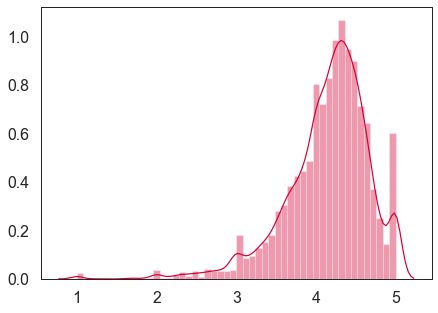

In [124]:
plt.figure(figsize=(7, 5))
sns.distplot(products[products.rating >= 0].rating, color="#d50032")  #"#047495")
# plt.xlabel("Average Product Rating", fontsize=15)
plt.xlabel("")
plt.show()

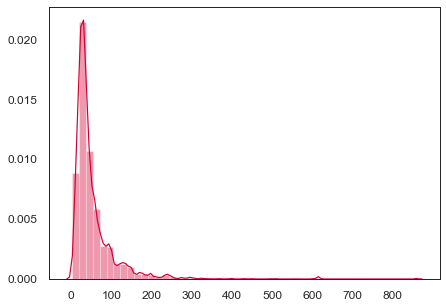

In [115]:
plt.figure(figsize=(7, 5))
sns.distplot(products.price_high, color="#d50032")
# plt.title("Retail Price in US$", fontsize=15)
# plt.text(580, 0.0255, "Note: Retail price of product's main variant", ha="right", va="top", fontsize="12")
plt.xticks(range(0, 900, 100), fontsize =12)
plt.yticks(fontsize =12)
plt.xlabel("")
plt.show()

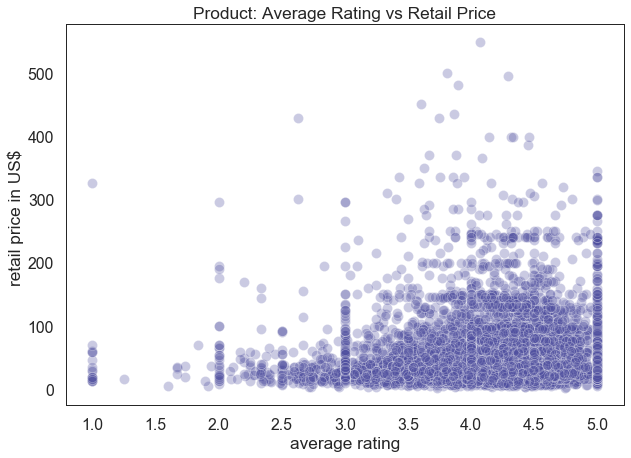

In [4]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x="rating", y="list_price", data=products, color="C4", marker="o", s=100, alpha=0.3)
plt.title("Product: Average Rating vs Retail Price")
plt.xlabel("average rating")
plt.ylabel("retail price in US$ ")
plt.show()

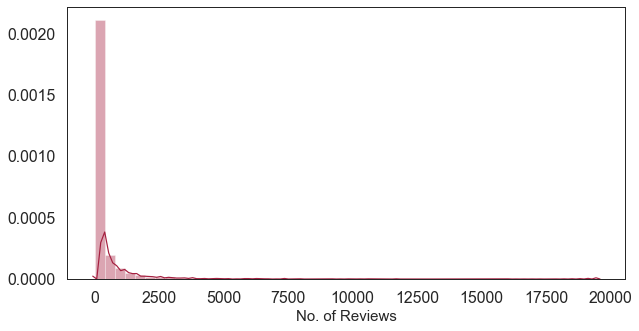

In [337]:
plt.figure(figsize=(10, 5))
sns.distplot(products.review_count, color="C1")#"#047495")
plt.xlabel("No. of Reviews", fontsize=15)
plt.show()

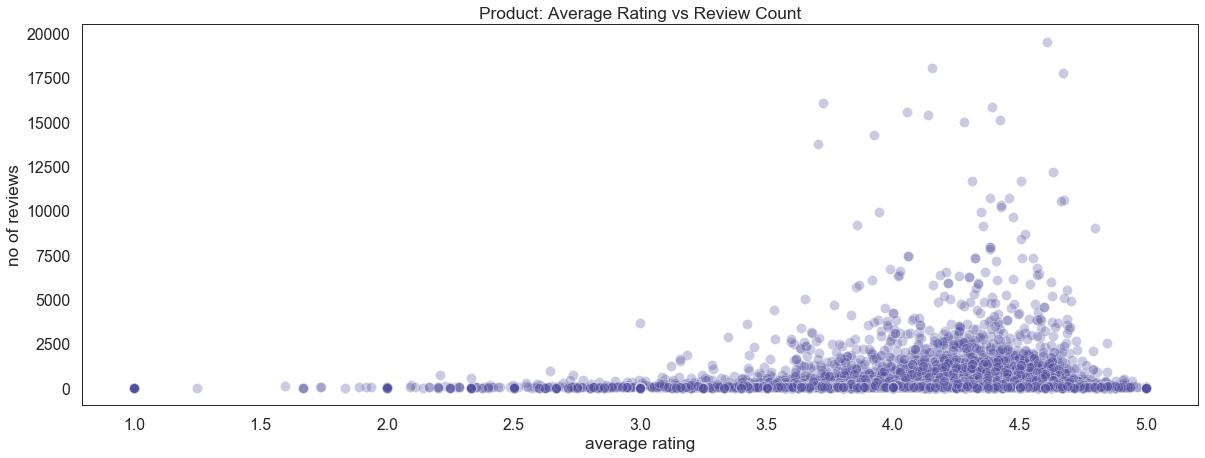

In [385]:
plt.figure(figsize=(20, 7))
sns.scatterplot(x="rating", y="review_count", data=products, color="C4", marker="o", s=100, alpha=0.3)
plt.title("Product: Average Rating vs Review Count")
plt.xlabel("average rating")
plt.ylabel("no of reviews")
plt.show()

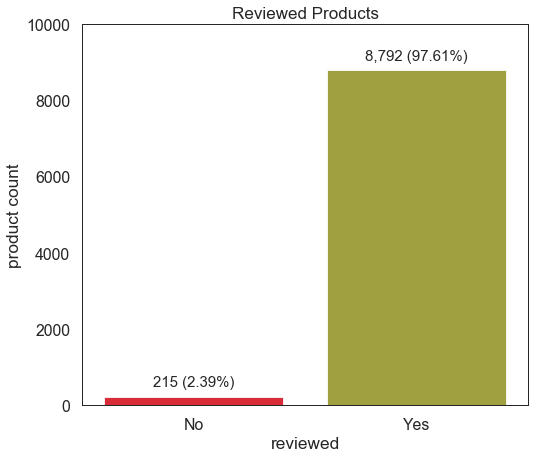

In [334]:
temp = products.groupby(["is_rated"]).count().reset_index()
plt.figure(figsize=(8, 7))
sns.barplot("is_rated", "id", data=temp, palette=["C0", "C10"])
plt.title("Reviewed Products", fontsize=17)
plt.ylabel("product count")
plt.xlabel("reviewed")
plt.yticks(range(0, 11000, 2000))
plt.xticks([0, 1], ["No", "Yes"])
for x, y in enumerate(temp.id):
    plt.text(x,
             y + 200,
             "{:,} ({}%)".format(y, round(y / len(products) * 100, 2)),
             fontsize=15,
             ha="center",
             va="bottom")
plt.show()
del temp, x, y

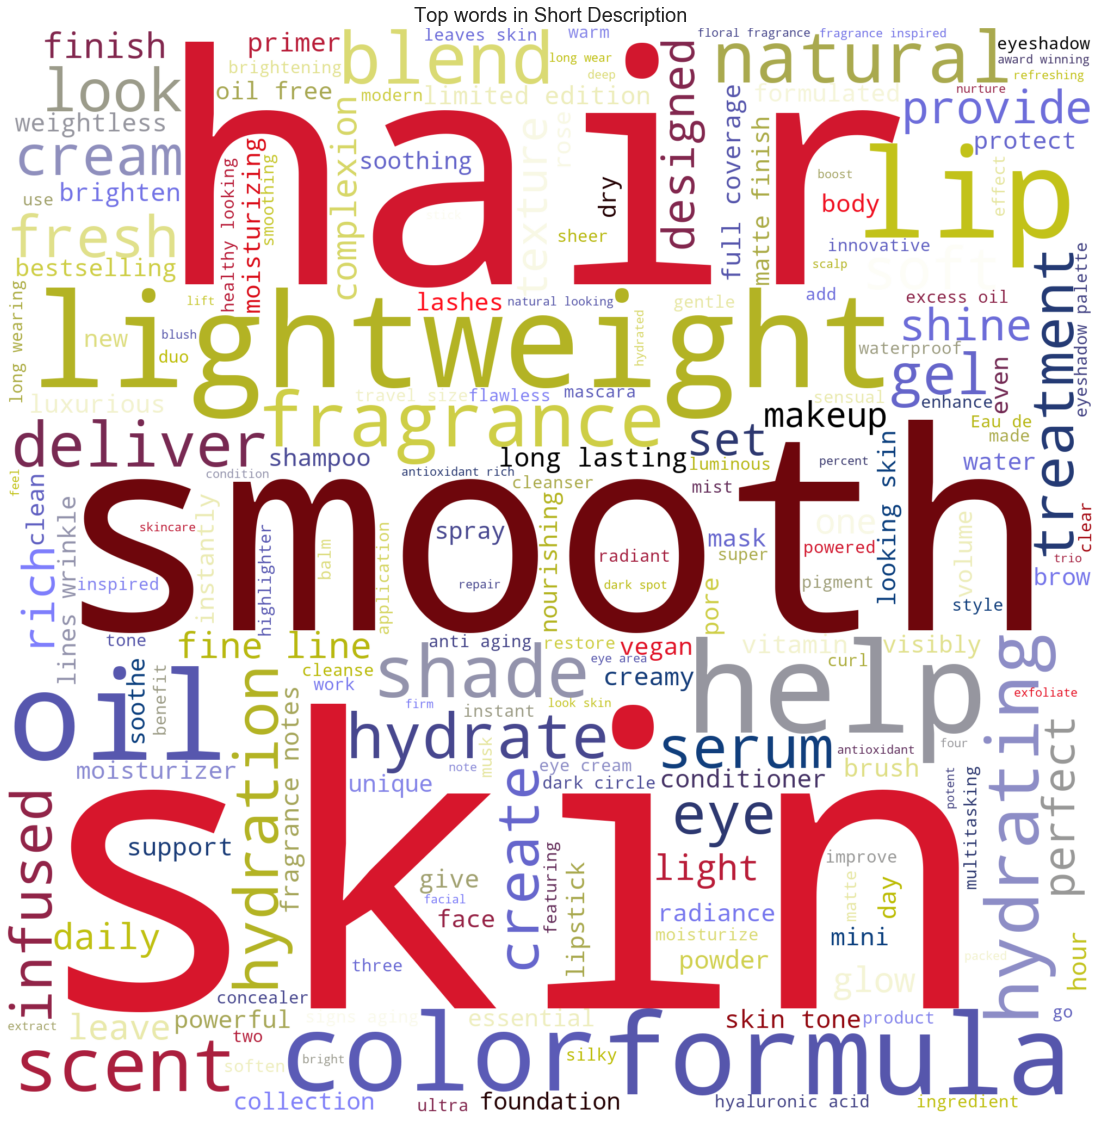

In [315]:
text = " ".join(str(x) for x in products.short_desc)

stopwords = set(STOPWORDS)
# stopwords.update([""])



plt.figure(figsize=[20, 20])
wordcloud = WordCloud(max_font_size=None,
                      width=2000,
                      height=2000,
                      stopwords=None,
                      background_color="white",
                      random_state=42,
                      repeat=False,
                      max_words=200,
                      colormap="gist_stern").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Top words in Short Description', fontsize=20)
plt.axis("off")
plt.show()

del text

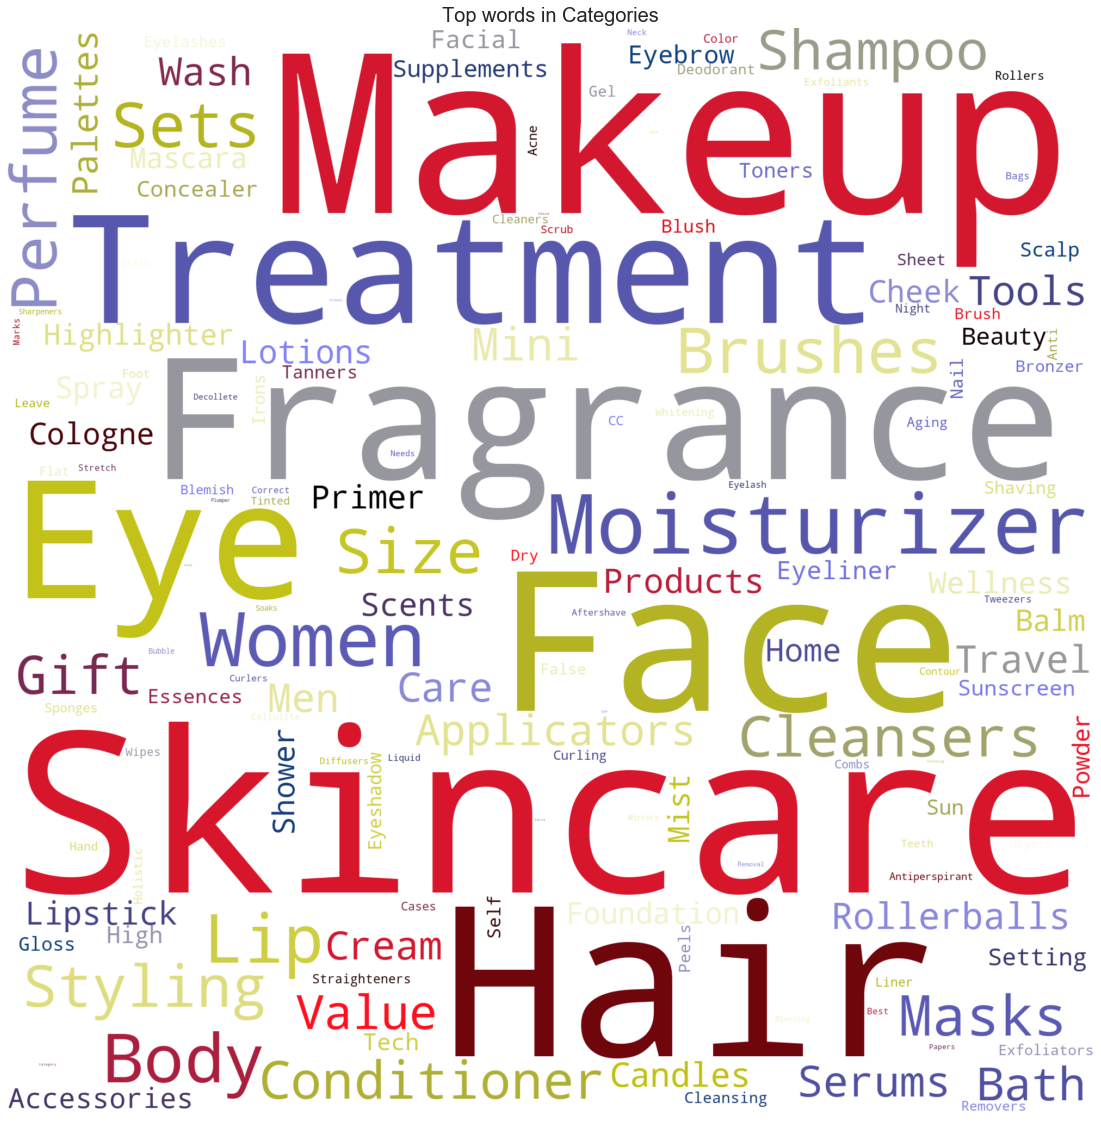

In [314]:
text = list(
    json.loads(x.replace("\'", "\"")) for x in products.categories
    if type(x) == str)
text = " ".join(" ".join(list(x.values())) for x in text)

# heart_mask = np.array(Image.open("heart.png"))

plt.figure(figsize=[20, 20])
wordcloud = WordCloud(max_font_size=None,
                      width=2000,
                      height=2000,
                      stopwords=None,
                      background_color="white",
                      random_state=42,
                      repeat=False,
                      collocations=False,
                      max_words=200,
                      colormap="gist_stern").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Top words in Categories', fontsize=20)
plt.axis("off")
plt.show()

del text

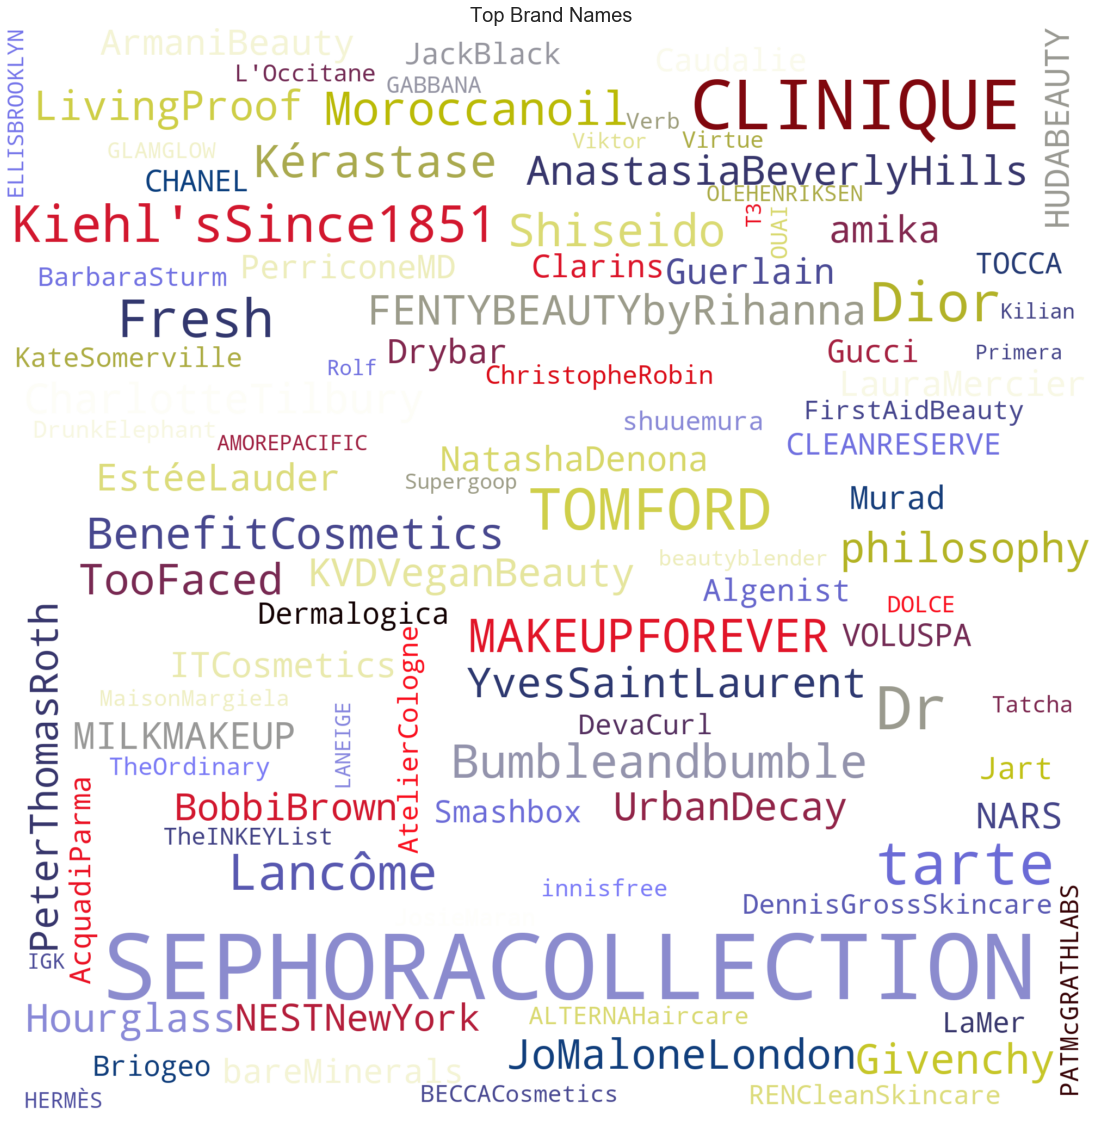

In [313]:
text = " ".join(str(x).replace(" ", "") for x in products.brand_name)

plt.figure(figsize=[20, 20])
wordcloud = WordCloud(max_font_size=None,
                      width=2000,
                      height=2000,
                      stopwords=None,
                      background_color="white",
                      random_state=42,
                      repeat=False,
                      collocations=False,
                      max_words=100,
                      colormap="gist_stern").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Top Brand Names', fontsize=20)
plt.axis("off")
plt.show()

del text

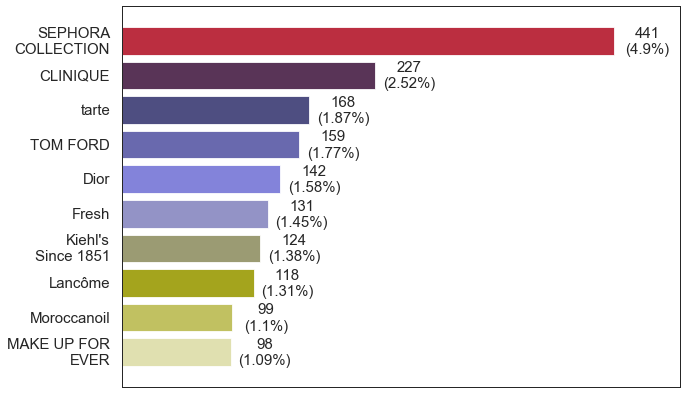

,brand_name,id,name,brand_id,short_desc,long_desc,item,item_name,list_price,variation,variants,price_low,price_high,is_limited_edition,rating,review_count,user_favorites,categories,url,image_url,ingredients,suggested_usage,brand_long,has_variants,has_categories,has_ingredients,has_suggested_usage,is_rated,cologne,men,fragrance,perfume,women,lotions_and_oils,rollerballs_and_travel_size,perfume_gift_sets,value_and_gift_sets,lipstick,lip,makeup,lip_balms_and_treatments,lip_treatments,mascara,eye,lip_gloss,eyebrow,body_sprays_and_deodorant,bath_and_shower,cologne_gift_sets,body_mist_and_hair_mist,concealer,face,lip_stain,deodorant_and_antiperspirant,body_care,bath_and_body,face_primer,foundation,tinted_moisturizer,face_serums,treatments,skincare,mists_and_essences,moisturizers,highlighter,liquid_lipstick,lip_sets,face_sets,setting_spray_and_powder,aftershave,shaving,eye_creams_and_treatments,eye_care,face_masks,masks,face_wash_and_cleansers,cleansers,exfoliators,makeup_removers,eyeliner,face_brushes,makeup_brushes_and_applicators,makeup_palettes,eye_palettes,bb_and_cc_creams,blush,cheek,facial_peels,eyelash_curlers,accessories,eye_sets,mini_size,bronzer,face_oils,contour,lip_liner,eyeshadow,face_wash,moisturizer_and_treatments,toners,body_lotions_and_body_oils,body_moisturizers,scrub_and_exfoliants,self_tanners,face_sunscreen,sun_care,blemish_and_acne_treatments,facial_cleansing_brushes,high_tech_tools,for_face,color_correct,skincare_sets,decollete_and_neck_creams,hand_cream_and_foot_cream,candles_and_home_scents,night_creams,sheet_masks,eye_brushes,beauty_supplements,wellness,facial_rollers,body_sunscreen,cellulite_and_stretch_marks,for_body,body_wash_and_shower_gel,nail,other_needs,shampoo_and_conditioner,hair,hair_styling_and_treatments,conditioner,shampoo,eye_masks,eye_primer,mirrors_and_sharpeners,tools_and_brushes,cheek_palettes,face_wipes,tweezers_and_eyebrow_tools,hair_accessories,hair_tools,gift_cards,false_eyelashes,brush_sets,brush_cleaners,makeup_and_travel_cases,hair_removal,lip_brushes,sponges_and_applicators,makeup_bags_and_travel_cases,hair_masks,curling_irons,hair_straighteners_and_flat_irons,hair_dryers,dry_shampoo,hair_brushes_and_combs,scalp_and_hair_treatments,bath_soaks_and_bubble_bath,hair_styling_products,blotting_papers,hair_primers,hair_oil,teeth_whitening,anti_aging,travel_size,facial_men,candles,diffusers,holistic_wellness,leave_in_conditioner,hair_spray,color_care,best_for,just_arrived,gifts_her,gifts_men,gifts_them,gifts_teens,gift_sets_men,gift_sets,editors_picks,luxury_gifts,sephora_exclusives,perfume_men,grooming_men,hair_men,personal_care_men,just_arrived_men,best_seller_men,vegan,cruelty_free,for_men
0,SEPHORA COLLECTION,441,441,441,431,431,441,311,441,441,164,441,441,441,423,441,441,441,441,441,262,356,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441,441
1,CLINIQUE,227,227,227,227,227,227,197,227,227,123,227,227,227,222,227,227,227,227,227,223,190,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,227,2

In [89]:
temp = products.groupby(["brand_name"]).count().sort_values(
    "id", ascending=False).reset_index().head(10)

plt.figure(figsize=(10, 7))
sns.barplot(y="brand_name", x="id", data=temp, palette="gist_stern")
# plt.title("Top Brands", fontsize=30)
# plt.text(9.45,
#          480,
#          "Note: top 10 brands in terms of product count",
#          ha="right",
#          fontsize=15)

for x, y in enumerate(temp.id):
    plt.text(y+30,
             x,
             "{:,}\n({}%)".format(y, round(y / len(products) * 100, 2)),
             fontsize=15,
             ha="center",
             va="center")

plt.xticks(range(0, 520, 20), labels=[])
plt.yticks(range(-1, 11, 1), [""]+[textwrap.fill(label, 12) for label in temp.brand_name],
           ha="right",
           va="center",
           fontsize=15)
plt.ylabel("", fontsize=20)
plt.xlabel("", fontsize=20)
plt.show()

display(temp)

del temp, x, y

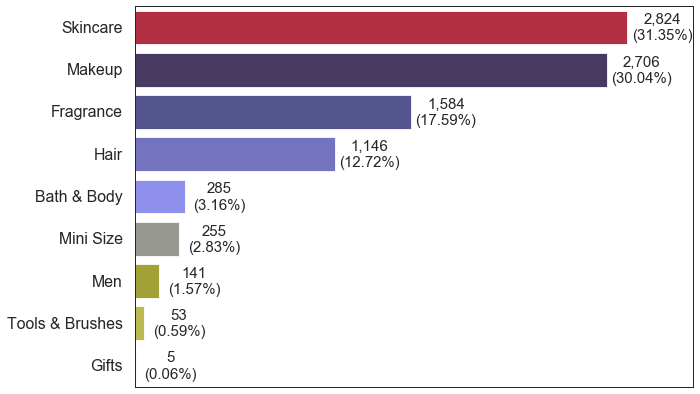

,categories,id
0,Skincare,2824
1,Makeup,2706
2,Fragrance,1584
3,Hair,1146
4,Bath & Body,285
5,Mini Size,255
6,Men,141
7,Tools & Brushes,53
8,Gifts,5


In [107]:
temp = products[["categories",
                 "id"]].copy()  #.groupby(["id"]).count().reset_index()
temp["categories"] = temp.categories.map(
    lambda x: list(json.loads(x.replace("\'", "\"")).values())[-1],
    na_action="ignore")
temp = temp.groupby(["categories"]).count().sort_values(
    "id", ascending=False).reset_index().iloc[:-1]

plt.figure(figsize=(10, 7))
sns.barplot(y="categories", x="id", data=temp, palette="gist_stern")
# plt.title("Main Categories", fontsize=25)

for x, y in enumerate(temp.id):
    plt.text(y + 200,
             x,
             "{:,}\n({}%)".format(y, round(y / len(products) * 100, 2)),
             fontsize=15,
             ha="center",
             va="center")

plt.xticks(range(0, 3400, 200), labels=[])
plt.yticks(ha="right", va="center")
plt.ylabel("")
plt.xlabel("")
plt.show()

display(temp)

del temp, x, y

In [428]:
del products

In [627]:
# Review stats

product_reviewstats = pd.read_csv("reviewstats2.csv")
product_reviewstats

,id,review_count,recommended_count,not_recommended_count,average_rating,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,age_13to17_count,age_18to24_count,age_25to34_count,age_35to44_count,age_45to54_count,age_over54_count,skintone_fair_count,skintone_light_count,skintone_medium_count,skintone_olive_count,skintone_deep_count,skintone_dark_count,skintone_porcelain_count,skintone_tan_count,skintone_ebony_count,skintype_normal_count,skintype_combination_count,skintype_dry_count,skintype_oily_count,skinconcerns_acne_count,skinconcerns_aging_count,skinconcerns_blackheads_count,skinconcerns_calluses_count,skinconcerns_cellulite_count,skinconcerns_cuticles_count,skinconcerns_darkcircles_count,skinconcerns_dullness_count,skinconcerns_pores_count,skinconcerns_redness_count,skinconcerns_sensitivity_count,skinconcerns_stretchmarks_count,skinconcerns_sundamage_count,skinconcerns_unevenskintones_count,skinconcerns_puffiness_count,eyecolor_blue_count,eyecolor_brown_count,eyecolor_green_count,eyecolor_hazel_count,eyecolor_gray_count,haircolor_blonde_count,haircolor_brunette_count,haircolor_auburn_count,haircolor_black_count,haircolor_red_count,haircolor_gray_count,haircondition_normal_count,haircondition_oily_count,haircondition_dry_count,haircondition_fine_count,haircondition_coarse_count,haircondition_curly_count,haircondition_chemicallytreated_count,haircondition_straight_count,haircondition_wavy_count,hairconcerns_antiaging_count,hairconcerns_colorprotection_count,hairconcerns_curlyenhancing_count,hairconcerns_damage_count,hairconcerns_dandruff_count,hairconcerns_frizz_count,hairconcerns_heatprotection_count,hairconcerns_hold_count,hairconcerns_oiliness_count,hairconcerns_shine_count,hairconcerns_straighteningsmoothing_count,hairconcerns_volumizing_count,hairconcerns_thinning_count,staffcontext_true_count,staffcontext_false_count,incentivizedreview_true_count,incentivizedreview_true_count.1
0,P163103,1858,375,34,4.56,42,52,101,294,1369,41,368,396,141,94,44,71,120,82,22,18,16,22,28,6,53,215,65,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,211,44,45,2,69,188,17,94,11,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,523,64,64
1,P12045,1348,590,85,4.44,46,46,88,261,907,4,59,109,54,26,24,207,215,157,56,28,14,48,57,2,79,476,176,86,297,123,44,1,4,4,41,21,2,23,25,1,5,4,0,115,370,66,75,4,112,304,16,182,21,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,548,3,3
2,P386462,348,111,34,4.12,30,25,28,55,210,2,19,55,28,17,10,41,31,34,4,3,2,11,7,0,18,76,28,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,51,27,20,3,37,67,9,16,3,4,18,4,13,26,9,17,34,1,0,24,25,7,35,7,18,3,1,1,3,1,3,0,1,179,17,17
3,P425604,46,35,11,4.20,2,3,4,12,25,1,1,1,3,2,4,14,15,5,2,1,0,4,5,0,4,26,8,8,10,7,3,0,0,0,3,1,0,1,0,0,0,1,0,5,25,7,7,1,12,22,4,7,1,0,0,0,1,0,0,0,2,0,0,2,6,2,0,2,5,1,0,0,0,0,0,1,0,18,0,0
4,P398009,2748,1053,220,3.99,169,231,338,727,1283,67,225,231,55,35,42,376,402,362,145,130,75,161,94,19,261,896,288,306,578,181,110,2,9,3,135,30,4,31,23,2,7,19,0,365,933,211,190,20,259,578,52,274,47,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1767,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,P456594,21,13,8,3.43,4,3,1,6,7,0,1,2,0,0,2,2,9,3,1,3,0,3,0,0,3,8,5,5,10,4,1,0,0,0,2,2,0,0,0,0,1,0,0,4,12,4,1,0,3,11,2,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,20,0,0
8785,P427718,261,160,101,3.61,54,30,19,20,138,1,10,17,6,3,4,58,76,60,16,10,3,15,12,0,36,145,37,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,128,31,41,3,66,120,5,55,6,1,4,1,14,7,5,3,35,0,5,35,55,9,72,13,23,3,1,6,9,4,9,3,1,119,4,4
8786,P459305,29,28,1,4.76,0,0,1,5,23,1,2,0,0,0,0,8,10,4,1,0,0,3,2,0,5,14,1,8,22,3,2,0,0,0,0,0,0,0,0,0,0,0,0,7,9,5,6,0,12,11,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,28,28
8787,P428818,22,15,7,4.00

In [628]:
product_reviewstats = pd.merge(products[["id", "name", "brand_name"]],
                               product_reviewstats,
                               how="right",
                               on="id")
product_reviewstats.head()

,id,name,brand_name,review_count,recommended_count,not_recommended_count,average_rating,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,age_13to17_count,age_18to24_count,age_25to34_count,age_35to44_count,age_45to54_count,age_over54_count,skintone_fair_count,skintone_light_count,skintone_medium_count,skintone_olive_count,skintone_deep_count,skintone_dark_count,skintone_porcelain_count,skintone_tan_count,skintone_ebony_count,skintype_normal_count,skintype_combination_count,skintype_dry_count,skintype_oily_count,skinconcerns_acne_count,skinconcerns_aging_count,skinconcerns_blackheads_count,skinconcerns_calluses_count,skinconcerns_cellulite_count,skinconcerns_cuticles_count,skinconcerns_darkcircles_count,skinconcerns_dullness_count,skinconcerns_pores_count,skinconcerns_redness_count,skinconcerns_sensitivity_count,skinconcerns_stretchmarks_count,skinconcerns_sundamage_count,skinconcerns_unevenskintones_count,skinconcerns_puffiness_count,eyecolor_blue_count,eyecolor_brown_count,eyecolor_green_count,eyecolor_hazel_count,eyecolor_gray_count,haircolor_blonde_count,haircolor_brunette_count,haircolor_auburn_count,haircolor_black_count,haircolor_red_count,haircolor_gray_count,haircondition_normal_count,haircondition_oily_count,haircondition_dry_count,haircondition_fine_count,haircondition_coarse_count,haircondition_curly_count,haircondition_chemicallytreated_count,haircondition_straight_count,haircondition_wavy_count,hairconcerns_antiaging_count,hairconcerns_colorprotection_count,hairconcerns_curlyenhancing_count,hairconcerns_damage_count,hairconcerns_dandruff_count,hairconcerns_frizz_count,hairconcerns_heatprotection_count,hairconcerns_hold_count,hairconcerns_oiliness_count,hairconcerns_shine_count,hairconcerns_straighteningsmoothing_count,hairconcerns_volumizing_count,hairconcerns_thinning_count,staffcontext_true_count,staffcontext_false_count,incentivizedreview_true_count,incentivizedreview_true_count.1
0,P180726,Pour Homme II,Gucci,114,4,2,4.81,2,0,2,10,100,4,24,39,18,2,1,0,1,1,1,0,0,0,3,0,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0
1,P224900,Gucci By Gucci Pour Homme,Gucci,145,2,1,4.72,1,2,7,16,119,1,27,59,15,15,2,0,2,0,0,1,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0,0
2,P237121,Flora By Gucci Eau de Toilette,Gucci,514,10,1,4.53,9,19,27,94,365,12,148,165,71,39,13,2,3,3,1,1,0,1,0,0,2,6,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,2,2,0,3,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36,1,1
3,P257520,Flora by Gucci Eau de Parfum,Gucci,161,40,4,4.70,3,2,6,18,132,6,39,44,8,5,6,8,8,10,6,2,2,3,3,0,7,21,6,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,29,4,2,0,7,22,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,5,5
4,P273900,Guilty,Gucci,843,81,16,4.39,41,30,59,141,572,20,154,247,98,44,34,13,25,25,5,4,8,2,6,1,19,46,13,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,48,10,7,2,21,34,6,20,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,170,17,17


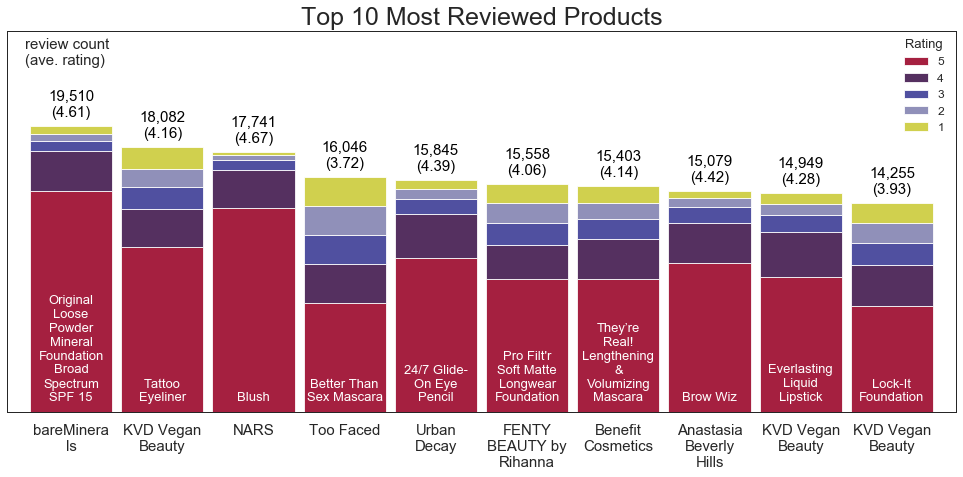

,id,name,brand_name,review_count,rating_1_count,rating_2_count,rating_3_count,rating_4_count,rating_5_count,average_rating
0,P61003,Original Loose Powder Mineral Foundation Broad Spectrum SPF 15,bareMinerals,19510,529,465,706,2748,15062,4.61
1,P245205,Tattoo Eyeliner,KVD Vegan Beauty,18082,1500,1248,1461,2603,11270,4.16
2,P2855,Blush,NARS,17741,202,347,716,2538,13938,4.67
3,P381000,Better Than Sex Mascara,Too Faced,16046,2003,1970,1956,2679,7438,3.72
4,P133707,24/7 Glide-On Eye Pencil,Urban Decay,15845,634,707,1034,2944,10526,4.39
5,P87985432,Pro Filt'r Soft Matte Longwear Foundation,FENTY BEAUTY by Rihanna,15558,1298,1405,1460,2350,9045,4.06
6,P289307,They’re Real! Lengthening & Volumizing Mascara,Benefit Cosmetics,15403,1152,1061,1370,2744,9076,4.14
7,P202633,Brow Wiz,Anastasia Beverly Hills,15079,479,621,1103,2734,10142,4.42
8,P384954,Everlasting Liquid Lipstick,KVD Vegan Beauty,14949,788,751,1135,3062,9213,4.28
9,P311138,Lock-It Foundation,KVD Vegan Beauty,14255,1345,1356,1547,2781,7226,3.93


In [701]:
temp = product_reviewstats.sort_values(
    "review_count", ascending=False).copy().reset_index(drop=True).head(11)[[
        "id", "name", "brand_name", "review_count", "rating_1_count",
        "rating_2_count", "rating_3_count", "rating_4_count", "rating_5_count",
        "average_rating"
    ]]
temp.drop(index=4, inplace=True)
temp.reset_index(drop=True, inplace=True)
temp[[
    "name", "rating_5_count", "rating_4_count", "rating_3_count",
    "rating_2_count", "rating_1_count"
]].set_index("name").plot(kind='bar',
                          stacked=True,
                          figsize=(17, 7),
                          width=0.9,
                          color=["C1", "C2", "C4", "C8", "C12"])
plt.ylabel("")
plt.xlabel("")
plt.yticks(range(0, 27000, 1000), labels=[])
plt.xticks(range(10), [textwrap.fill(label, 10) for label in temp.brand_name],
           ha="center",
           va="top",
           wrap=True,
           fontsize=15,
           rotation=0)
plt.text(-0.5,
         23500,
         "review count\n(ave. rating)",
         va="bottom",
         ha="left",
         fontsize=15)
for x, y in enumerate(temp.review_count):
    plt.text(x,
             y + 400,
             "{:,}\n({})".format(y, round(temp.average_rating.iloc[x], 2)),
             va="bottom",
             ha="center",
             fontsize=15,
             color="black")
    plt.text(x,
             500,
             textwrap.fill(temp.name.iloc[x], 11),
             va="bottom",
             ha="center",
             color="white",
             fontsize=13)
plt.title("Top 10 Most Reviewed Products", fontsize=25)
plt.legend(title="Rating",
           title_fontsize=13,
           labels=[5, 4, 3, 2, 1],
           loc=(.94, 0.72),
           fontsize=12)
plt.show()

display(temp)
del temp

In [712]:
cols = [col for col in product_reviewstats.columns if col.startswith("age_")]
print(cols)
cols.sort(reverse=True)
cols

['age_13to17_count', 'age_18to24_count', 'age_25to34_count', 'age_35to44_count', 'age_45to54_count', 'age_over54_count']


['age_over54_count',
 'age_45to54_count',
 'age_35to44_count',
 'age_25to34_count',
 'age_18to24_count',
 'age_13to17_count']

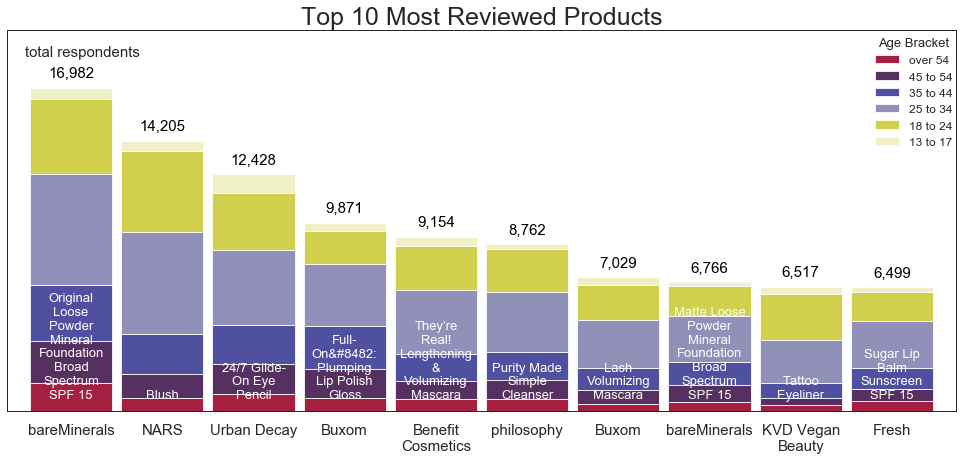

,id,name,brand_name,review_count,average_rating,age_over54_count,age_45to54_count,age_35to44_count,age_25to34_count,age_18to24_count,age_13to17_count,total_respondents
0,P61003,Original Loose Powder Mineral Foundation Broad Spectrum SPF 15,bareMinerals,19510,4.61,1446,2210,2975,5831,3911,609,16982
1,P2855,Blush,NARS,17741,4.67,675,1265,2106,5360,4260,539,14205
2,P133707,24/7 Glide-On Eye Pencil,Urban Decay,15845,4.39,879,1569,2037,3973,3010,960,12428
3,P174213,Full-On&#8482: Plumping Lip Polish Gloss,Buxom,12182,4.63,694,1498,2245,3294,1721,419,9871
4,P289307,They’re Real! Lengthening & Volumizing Mascara,Benefit Cosmetics,15403,4.14,600,947,1418,3395,2308,486,9154
5,P7109,Purity Made Simple Cleanser,philosophy,11666,4.50,613,1009,1481,3160,2223,276,8762
6,P228204,Lash Volumizing Mascara,Buxom,9137,4.36,373,728,1129,2551,1844,404,7029
7,P240604,Matte Loose Powder Mineral Foundation Broad Spectrum SPF 15,bareMinerals,7810,4.38,437,895,1249,2405,1556,224,6766
8,P245205,Tattoo Eyeliner,KVD Vegan Beauty,18082,4.16,295,374,784,2294,2371,399,6517
9,P57002,Sugar Lip Balm Sunscreen SPF 15,Fresh,9603,4.48,496,643,1097,2484,1506,273,6499


In [714]:
cols = [col for col in product_reviewstats.columns if col.startswith("age_")]
cols.sort(reverse=True)
temp = product_reviewstats.copy().sort_values(
    "review_count", ascending=False).head(100)[
        ["id", "name", "brand_name", "review_count", "average_rating"] + cols]
temp["total_respondents"] = temp[cols].T.sum().values

temp = temp.sort_values("total_respondents",
                        ascending=False).reset_index(drop=True).head(10)

temp[["name"] + cols].set_index("name").plot(
    kind='bar',
    stacked=True,
    figsize=(17, 7),
    width=0.9,
    color=["C1", "C2", "C4", "C8", "C12", "C14"])
plt.ylabel("")
plt.xlabel("")
plt.yticks(range(0, 21000, 1000), labels=[])
plt.xticks(range(10), [textwrap.fill(label, 15) for label in temp.brand_name],
           ha="center",
           va="top",
           wrap=True,
           fontsize=15,
           rotation=0)
plt.text(-0.5, 18500, "total respondents", va="bottom", ha="left", fontsize=15)
for x, y in enumerate(temp.total_respondents):
    plt.text(x,
             y + 400,
             "{:,}".format(y),
             va="bottom",
             ha="center",
             fontsize=15,
             color="black")
    plt.text(x,
             500,
             textwrap.fill(temp.name.iloc[x], 11),
             va="bottom",
             ha="center",
             color="white",
             fontsize=13)
plt.title("Top 10 Most Reviewed Products", fontsize=25)
plt.legend(title="Age Bracket",
           title_fontsize=13,
           labels=[
               "over 54", "45 to 54", "35 to 44", "25 to 34", "18 to 24",
               "13 to 17"
           ],
           loc=(.91, 0.68),
           fontsize=12)
plt.show()

display(temp)
del temp

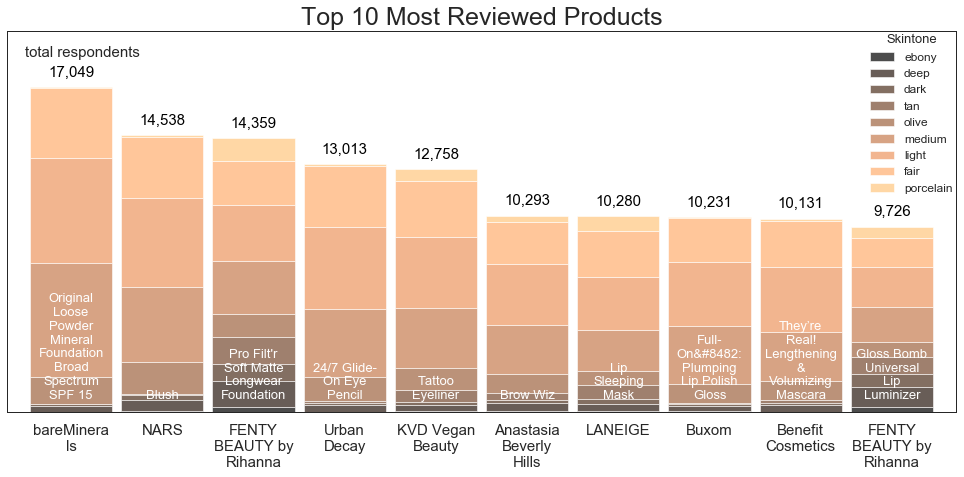

,id,name,brand_name,review_count,average_rating,skintone_ebony_count,skintone_deep_count,skintone_dark_count,skintone_tan_count,skintone_olive_count,skintone_medium_count,skintone_light_count,skintone_fair_count,skintone_porcelain_count,total_respondents
0,P61003,Original Loose Powder Mineral Foundation Broad Spectrum SPF 15,bareMinerals,19510,4.61,0,286,92,25,1429,5955,5540,3681,41,17049
1,P2855,Blush,NARS,17741,4.67,7,617,247,74,1659,3968,4677,3202,87,14538
2,P87985432,Pro Filt'r Soft Matte Longwear Foundation,FENTY BEAUTY by Rihanna,15558,4.06,218,1384,906,1396,1200,2796,2958,2323,1178,14359
3,P133707,24/7 Glide-On Eye Pencil,Urban Decay,15845,4.39,3,329,121,83,1301,3560,4328,3179,109,13013
4,P245205,Tattoo Eyeliner,KVD Vegan Beauty,18082,4.16,27,328,129,651,1160,3158,3722,2946,637,12758
5,P202633,Brow Wiz,Anastasia Beverly Hills,15079,4.42,39,408,155,360,1018,2591,3195,2185,342,10293
6,P420652,Lip Sleeping Mask,LANEIGE,10771,4.46,57,368,240,748,733,2134,2811,2407,782,10280
7,P174213,Full-On&#8482: Plumping Lip Polish Gloss,Buxom,12182,4.63,8,262,115,63,1021,3034,3362,2307,59,10231
8,P289307,They’re Real! Lengthening & Volumizing Mascara,Benefit Cosmetics,15403,4.14,5,331,139,123,999,2593,3414,2388,139,10131
9,P67988453,Gloss Bomb Universal Lip Luminizer,FENTY BEAUTY by Rihanna,10561,4.66,224,1046,710,890,788,1837,2085,1553,593,9726


In [751]:
cols = [
    "skintone_" + col + "_count" for col in [
        "ebony", "deep", "dark", "tan", "olive", "medium", "light", "fair",
        "porcelain"
    ]
]
temp = product_reviewstats.copy().sort_values(
    "review_count", ascending=False).head(100)[
        ["id", "name", "brand_name", "review_count", "average_rating"] + cols]
temp["total_respondents"] = temp[cols].T.sum().values

temp = temp.sort_values("total_respondents",
                        ascending=False).reset_index(drop=True).head(10)

temp[["name"] + cols].set_index("name").plot(kind='bar',
                                             stacked=True,
                                             figsize=(17, 7),
                                             width=0.9,
                                             cmap="copper",
                                             alpha=0.7)
plt.ylabel("")
plt.xlabel("")
plt.yticks(range(0, 21000, 1000), labels=[])
plt.xticks(range(10), [textwrap.fill(label, 10) for label in temp.brand_name],
           ha="center",
           va="top",
           wrap=True,
           fontsize=15,
           rotation=0)
plt.text(-0.5, 18500, "total respondents", va="bottom", ha="left", fontsize=15)
for x, y in enumerate(temp.total_respondents):
    plt.text(x,
             y + 400,
             "{:,}".format(y),
             va="bottom",
             ha="center",
             fontsize=15,
             color="black")
    plt.text(x,
             500,
             textwrap.fill(temp.name.iloc[x], 11),
             va="bottom",
             ha="center",
             color="white",
             fontsize=13)
plt.title("Top 10 Most Reviewed Products", fontsize=25)
plt.legend(title="Skintone",
           title_fontsize=13,
           labels=[
               col.replace("skintone_", "").replace("_count", "")
               for col in cols
           ],
           loc=(.905, 0.56),
           fontsize=12)
plt.show()

display(temp)
del temp

In [4]:
# Product reviews for the past 2 years where users recommended and rated the product 3 or above.

product_reviews = pd.read_csv("selected_reviews_short.csv")
product_reviews

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,product_id,author_id,date,review_id,rating,helpfulness,feedback_count,positive_feedback,negative_feedback,comment_count,review_title,review_text,skintype,eyecolor,skinconcerns,staffcontext,haircolor,skintone,incentivizedreview,verifiedpurchaser,age,hairconcerns,haircondition
0,P0417,5869746961,2019-09-14 17:16:59+00:00,135835739,3,0.67,3,2,1,0,NaN,"It doesn't help with blackheads at all, but it does with whiteheads. It is okay",combination,green,acne,False,brunette,light,False,NaN,NaN,NaN,NaN
1,P0417,22189528930,2019-07-07 17:48:13+00:00,130283148,3,1.00,5,5,0,0,NaN,"Be careful using this, it does extract pimples but only if they are at a head and ready to pop. Otherwise the harder you push to bring it out marks your skin. It’s better than using your nails and bruising your skin on stubborn pimples but still can damage your skin. The black head extractor does work fantastic, brings out the really stubborn black heads but then again also damages your skin if your press too hard. Trail and error learning how hard to press before making marks.",combination,blue,acne,False,black,medium,False,NaN,NaN,NaN,NaN
2,P0417,5641704837,2018-09-15 16:34:33+00:00,118730320,3,2.00,0,0,0,0,NaN,It works but I think it’s not as gentle as I would like. It can still cause trauma on your skin. So be gentle! Better than using your fingers.,combination,blue,acne,NaN,red,fair,NaN,NaN,NaN,NaN,NaN
3,P04546871,22081371793,2020-05-17 18:17:18+00:00,156485522,3,1.00,3,3,0,0,"She’s cute, glitter will get on your clothing",Bought this on sale and used it for a shoot at home. It’s super cute and feels very nice with amazing sparkle pay off in the light. Highly recommend using a body brush for this just to avoid it being clustered in your hands. The glitter will get on everything you touch your skin on as a heads up. Great for warm outings to amp your look.,combination,brown,acne,False,brunette,medium,False,NaN,NaN,NaN,NaN
4,P04546871,1440172327,2019-11-12 01:50:25+00:00,138255643,3,2.00,0,0,0,0,Beautiful but Sticky,The pay off the glitter is absolutely beautiful but it’s sticky. That is why I didn’t give this 4 stars.,combination,brown,aging,False,blonde,light,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939044,P99902,6041243828,2019-04-26 01:14:25+00:00,127314904,5,2.00,0,0,0,0,NaN,Love this Eyeliner. Stays in place,oily,hazel,NaN,False,brunette,light,False,NaN,NaN,NaN,NaN
939045,P99902,1334062044,2019-04-26 00:31:45+00:00,127313503,5,1.00,2,2,0,0,The only eyeliner you should own,"If you want a Truly Good Eyeliner buy this. Here is why I will only buy this brand and type of eyeliner 1. It doesnt irritate my eyes and cause eye boogers when using it on my waterline 2. It does NoT run. 3. It glides on without having to tug 4. It comes with a smudger at the end 5. It goes on properly the first time and if you want it extra thick, you can put it on another layer without causing that weird skipping effect. Yes it is absurdly expensive, but I dont have time for drama and problems when I am getting ready for work. It is worth it. Get it, but only get this one.",combination,NaN,NaN,False,black,olive,False,NaN,NaN,NaN,NaN
939046,P99902,5649540,2018-10-13 05:25:38+00:00,120021816,5,1.00,14,14,0,0,A must for an eyeliner that STAYS on!!!,"I am so highly impressed at this waterproof liner that I had to post about it.\nI lost my son in April and well, I cry a lot. I haven't been out much lately when when I do go out I use this liner since it is truly indelible like ink! I remove it with an oil based remover for bet removal. I get complements [I'm older too]. The Intense Brown and Captivating Blue is quite beautiful on eyes even over the black or brown..unlike all my others these just work and look best. I have a purple/plum shade not shown here plus more not seen on here but in teh stores are gorgeous on. There is a short smudge time after lining but it's so worth it. I own maybe 50 liners lol mid to 

In [318]:
product_reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939049 entries, 0 to 939048
Data columns (total 23 columns):
product_id            939049 non-null object
author_id             939049 non-null object
date                  939049 non-null object
review_id             939049 non-null int64
rating                939049 non-null int64
helpfulness           939049 non-null float64
feedback_count        939049 non-null int64
positive_feedback     939049 non-null int64
negative_feedback     939049 non-null int64
comment_count         939049 non-null int64
review_title          626091 non-null object
review_text           933305 non-null object
skintype              927402 non-null object
eyecolor              910739 non-null object
skinconcerns          547645 non-null object
staffcontext          654115 non-null object
haircolor             921205 non-null object
skintone              927301 non-null object
incentivizedreview    654115 non-null object
verifiedpurchaser     246517 non-null o